### Imports

In [1]:
import numpy as np
import cv2
import imutils
import matplotlib.pyplot as plt
from imutils import contours
import os
import glob

# For our classifiers
from sklearn.datasets import load_digits  
from sklearn import neighbors
import pickle

# For picture manipulation
from PIL import Image


### **Helper Functions**

In [39]:
IMAGE_PADDING = 4

def convert_to_grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def apply_gaussian_blur(img):
    return cv2.GaussianBlur(img, (5, 5), 1)

def apply_threshold(img):
    _, img = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY_INV)
    return img

def dilate(img, rows=1, cols=1, i=1):
    return cv2.dilate(img, np.ones((rows, cols), np.uint8), iterations=i)

def close(img, rows=1, cols=1):
    return cv2.morphologyEx(img, cv2.MORPH_CLOSE, np.ones((rows, cols), np.uint8))

def get_contours(img, rows=1, cols=1):
    cnts, _ = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = contours.sort_contours(cnts, method="left-to-right")[0]
    return cnts

def get_characters(img, cnts):
    chars = []
    for cnt in cnts:
    
        # Bounding rect
        (x, y, w, h) = cv2.boundingRect(cnt)
        chars.append(img[y:y+h,x:x+w])
        
    return np.asarray(chars)

def draw_contours(img, cnts):
    image = img.copy()
    for cnt in cnts:
        (x, y, w, h) = cv2.boundingRect(cnt)
        cv2.rectangle(image, (x, y), (x + w, y + h), (255,0,0), 3)
    plt.imshow(image, cmap='Greys_r')
    plt.show()        

def shape(img):
    
    h,w = img.shape
    aspect_ratio = w/h
    
    if aspect_ratio < 0.95:        
        padding = (h - w) // 2
        
        # Add width padding to create even aspect ratio
        img = cv2.copyMakeBorder(img,0,0,padding,padding,cv2.BORDER_CONSTANT,value=(0,0,0))
        
        # Dialate width to adjust for padding added to width
#         scale = int((1 - aspect_ratio) * 5)
#         img = cv2.dilate(img, np.ones((0,scale), np.uint8), iterations=2)
        
    elif aspect_ratio > 1.05:        
        padding = (w - h) // 2
        
         # Add width padding to create even aspect ratio
        img = cv2.copyMakeBorder(img,padding,padding,0,0,cv2.BORDER_CONSTANT,value=(0,0,0))
       
    # Resize
    img_size = 28 - IMAGE_PADDING * 2
    img = cv2.resize(img, (img_size, img_size))
    
    # add padding
    img = cv2.copyMakeBorder(img,IMAGE_PADDING,IMAGE_PADDING,IMAGE_PADDING,IMAGE_PADDING,cv2.BORDER_CONSTANT,value=(0,0,0))
    return img

### Load in Classifier

In [40]:
CLF = None
with open('../Classifier/clf.pk', 'rb') as fin:
    CLF = pickle.load(fin)

### Clear Indiviual Char Directory

In [41]:
files = glob.glob('./characters/*')
for f in files:
    os.remove(f)

### Load Image and Split Into Individual Chars

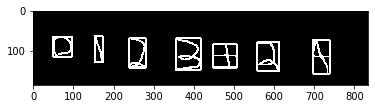

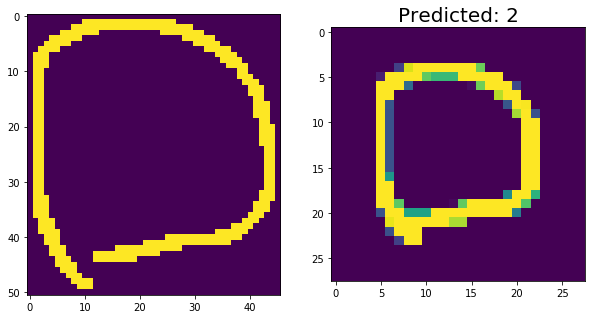

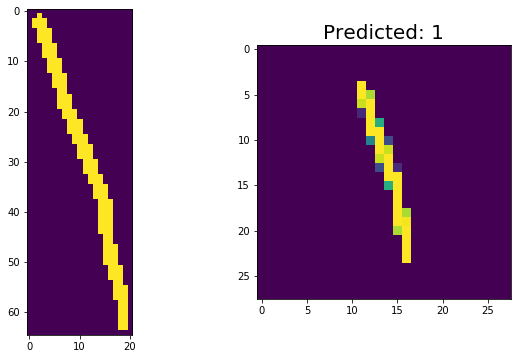

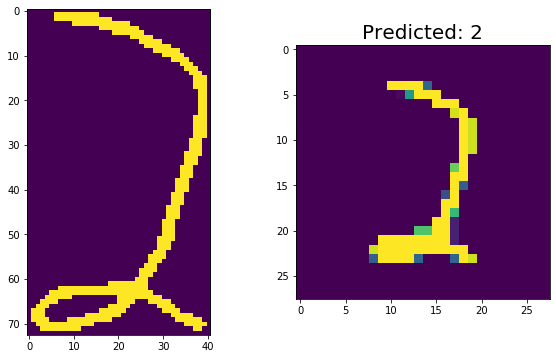

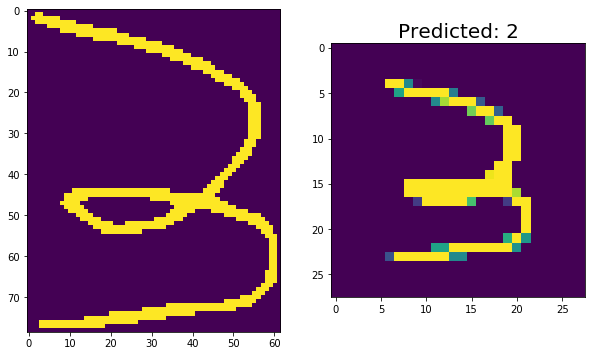

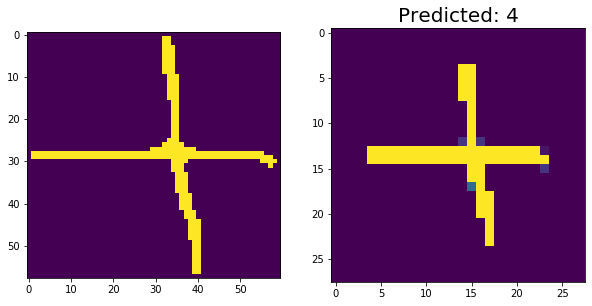

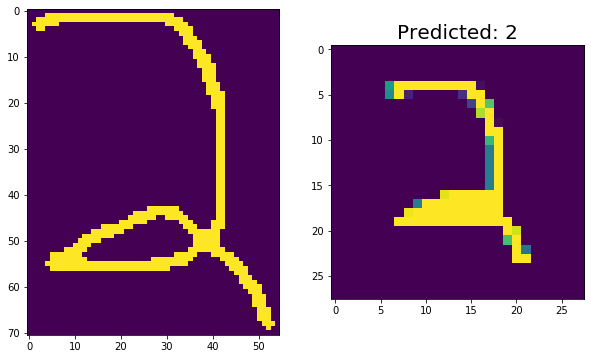

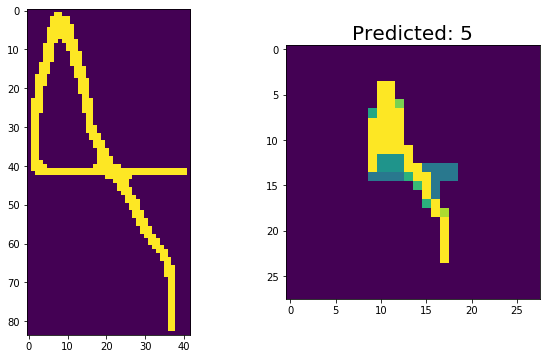

2122425


In [56]:
'''
TODO: 
    dialate after resize?
    close instad of dialate?
'''

# NOTE: Image must have a white background


# Load image
orig_img = cv2.imread("../img/image0.png")

# Perform adjustments
img = convert_to_grayscale(orig_img)
img = apply_gaussian_blur(img)
img = apply_threshold(img)
unchanged_img = img.copy()
img = dilate(img, 3, 3, 1)
# img = close(img, 3, 3)

# Contours
cnts = get_contours(img)

# Characters
orig_chars = get_characters(unchanged_img, cnts)
chars = get_characters(img, cnts)
draw_contours(img, cnts)

expression = ""
for (o_char, char) in zip(orig_chars, chars):
    
    # Shape image
    char_img = shape(char)
    char_img = close(char_img, 3, 3)

    
    # Predict
    expression += CLF.predict([char_img.ravel()])[0]
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(o_char)
    plt.subplot(1, 2, 2)
    plt.imshow(char_img)
    plt.title("Predicted: " + expression[-1], fontsize=20)
    plt.show()
    
print(expression)